https://zhuanlan.zhihu.com/p/646860740

In [1]:
!pip install qstock pywencai quantstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.1/911.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 71.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.1/110.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.0 MB/s eta 0:00:00
  Created wheel for qstock: filename=qstock-1.3.6-py3-none-any.whl size=159219 sha256=5dee99a99cb5ae09f035a3bef6cd93e9f4e220856190a1ba18942a225c67701c
  Stored in directory: /root/.ca

In [9]:
# colab 改中午字体
# !wget -O simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from matplotlib.font_manager import fontManager,FontProperties

# # 改style要在改font之前
# # plt.style.use('seaborn')
# font_path = 'simhei.ttf'
# font_prop = FontProperties(fname=font_path)
# plt.rcParams['font.family'] = font_prop.get_name()

--2023-11-02 02:13:18--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3037::6815:17f, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  13.2MB/s    in 0.7s    

2023-11-02 02:13:19 (13.2 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



In [10]:
import qstock
import numpy as np
import pandas as pd
pool_list = ['510300', '510500', '510880', '159915']
start_date = '20130729'
data = qstock.get_price(pool_list, start=start_date, freq='d', fqt=2).sort_index()
name_list = data.columns.tolist()
data.head()

,中证500ETF,沪深300ETF,红利ETF,创业板ETF
date,,,,
2013-07-29,0.962,2.254,1.808,1.124
2013-07-30,0.957,2.267,1.827,1.110
2013-07-31,0.963,2.272,1.832,1.122
2013-08-01,0.990,2.331,1.861,1.177
2013-08-02,0.992,2.327,1.856,1.169


In [11]:
N=20
for name in name_list:
  data['日收益率_'+name] = data[name]/data[name].shift(1) -1
  data['涨幅_'+name] = data[name]/data[name].shift(N+1)-1

data = data.dropna()
data[['涨幅_'+v for v in name_list]].head()

,涨幅_中证500ETF,涨幅_沪深300ETF,涨幅_红利ETF,涨幅_创业板ETF
date,,,,
2013-08-27,0.086279,0.074534,0.073009,0.093416
2013-08-28,0.085684,0.063520,0.056924,0.089189
2013-08-29,0.078920,0.058099,0.052948,0.075758
2013-08-30,0.038384,0.029601,0.036002,-0.005098
2013-09-02,0.038306,0.032230,0.040948,0.023952


In [12]:
# 取出每日涨幅最大的证券
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
# 今日的涨幅由昨日的持仓产生
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1)
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
data[['涨幅_'+v for v in name_list]+['信号','轮动策略日收益率','轮动策略净值']].head(10)

,涨幅_中证500ETF,涨幅_沪深300ETF,涨幅_红利ETF,涨幅_创业板ETF,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,
2013-08-28,0.085684,0.063520,0.056924,0.089189,创业板ETF,0.000000,1.000000
2013-08-29,0.078920,0.058099,0.052948,0.075758,创业板ETF,-0.001654,0.998346
2013-08-30,0.038384,0.029601,0.036002,-0.005098,中证500ETF,-0.010587,0.987776
2013-09-02,0.038306,0.032230,0.040948,0.023952,中证500ETF,0.001946,0.989698
2013-09-03,0.040634,0.033051,0.048128,0.017603,红利ETF,0.014493,1.004041
2013-09-04,0.029441,0.026105,0.042576,0.015886,红利ETF,-0.000510,1.003529
2013-09-05,0.048708,0.028826,0.047645,0.074010,红利ETF,-0.001021,1.002505
2013-09-06,0.054563,0.034322,0.058002,0.077711,创业板ETF,0.011218,1.013751
2013-09-09,0.057256,0.067511,0.116129,0.080965,创业板ETF,-0.005547,1.008128


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

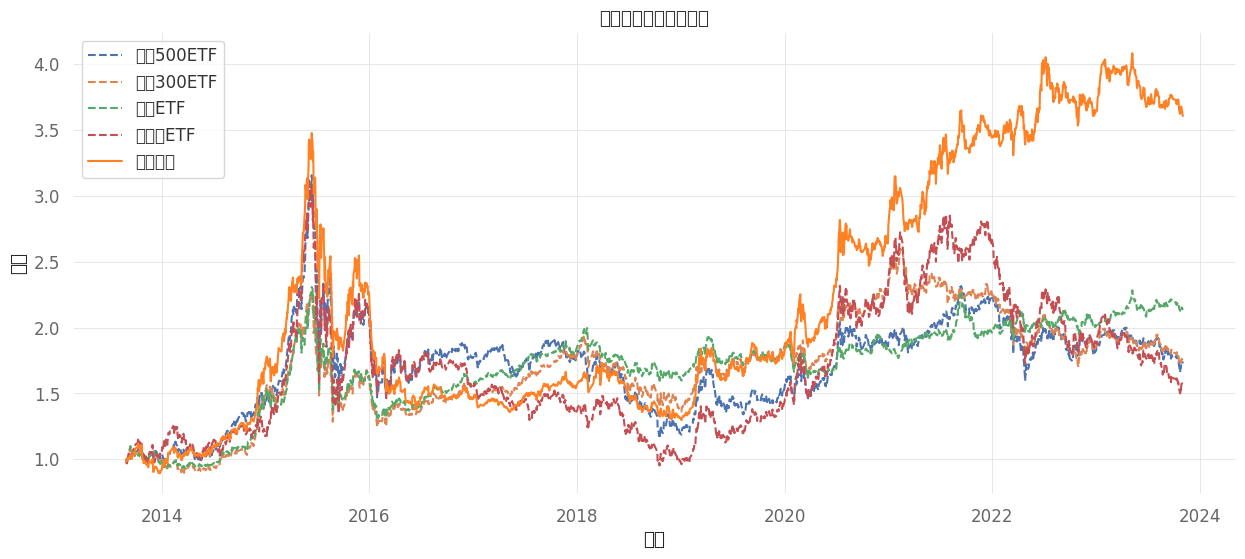

In [13]:
import matplotlib.pyplot as plt

# 显示中文设置
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比')

plt.show()

In [16]:
data['沪深300ETF净值']

date
2013-08-28    1.000000
2013-08-29    0.997097
2013-08-30    0.995438
2013-09-02    0.996267
2013-09-03    1.011199
                ...   
2023-10-27    1.756947
2023-10-30    1.763584
2023-10-31    1.760265
2023-11-01    1.759436
2023-11-02    1.761095
Name: 沪深300ETF净值, Length: 2468, dtype: float64

/usr/local/lib/python3.10/dist-packages/quantstats/_plotting/core.py:385: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/quantstats/_plotting/core.py:385: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/quantstats/_plotting/core.py:385: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/quantstats/_plotting/core.py:385: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/quantstats/_plotting/core.py:391: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from current font.
  _plt.savefig(**savefig)
/usr/local/lib/python3.10/dist-packages/quantstats/_plotting/core.py:391: UserWarning: Glyph 28

[Performance Metrics]

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2013-08-29   2013-08-29
End Period          2023-11-02   2023-11-02
Risk-Free Rate      0.0%         0.0%
Time in Market      99.0%        99.0%

Cumulative Return   76.11%       260.74%
CAGR﹪              3.91%        9.09%

Sharpe              0.37         0.63
Prob. Sharpe Ratio  87.73%       97.47%
Sortino             0.52         0.89
Sortino/√2          0.37         0.63
Omega               1.13         1.13

Max Drawdown        -44.37%      -62.7%
Longest DD Days     1978         2276

Gain/Pain Ratio     0.07         0.13
Gain/Pain (1M)      0.38         0.67

Payoff Ratio        1.03         1.08
Profit Factor       1.07         1.13
Common Sense Ratio  1.2          1.31
CPC Index           0.56         0.62
Tail Ratio          1.12         1.16
Outlier Win Ratio   4.58         3.79
Outlier Loss Ratio  5.26         4.48

MTD                 0.05%    

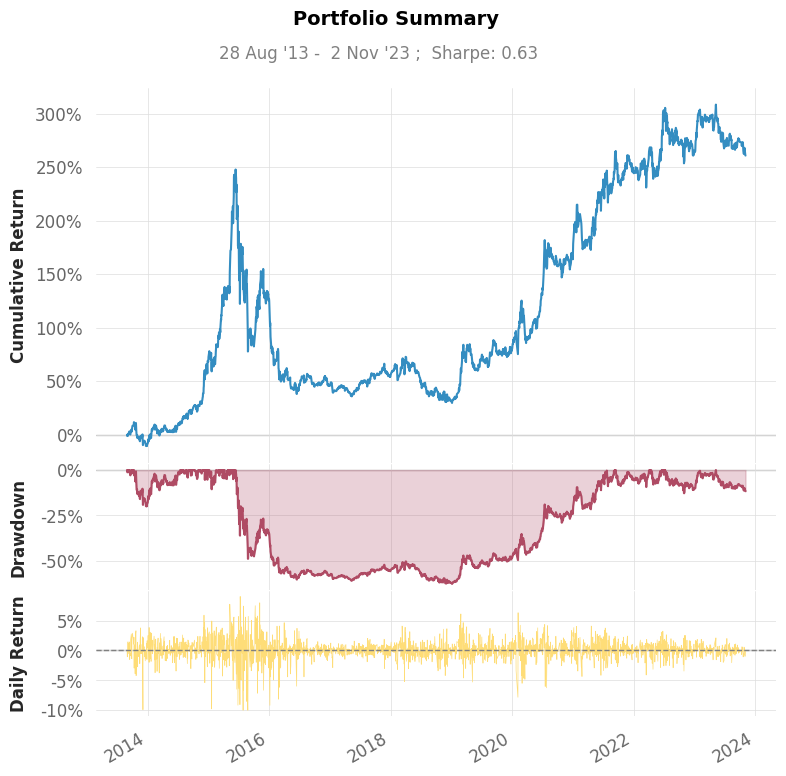

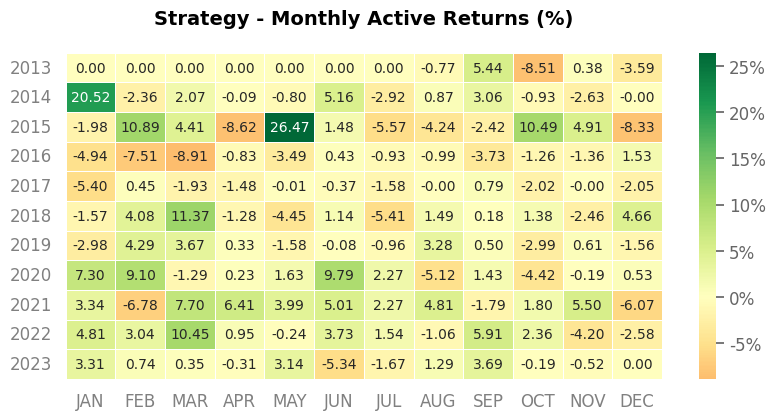

In [21]:
import quantstats as qstat

#将完整回测报告存为HTML文件
qstat.reports.html(data['轮动策略净值'], benchmark=data['沪深300ETF净值'],title='轮动策略回测报告',download_filename='轮动策略回测报告.html',output='my_report.html')

#输出基本回测报告信息
qstat.reports.basic(data['轮动策略净值'], benchmark=data['沪深300ETF净值'])